# **Import Modules**

In [2]:
import os # For handling the files
import pickle # Storing numpy features
import numpy as np # To do numerical operations
from tqdm.notebook import tqdm #To see how much images processed

from tensorflow.keras.preprocessing.image import load_img, img_to_array # To preprocess the image
from tensorflow.keras.preprocessing.text import Tokenizer # To preprocess the text
from tensorflow.keras.preprocessing.sequence import pad_sequences # To preprocess the sequence
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model # To get a representation of the model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add # NN layers
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt

# **Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing the VGG16 layer**

553467096/553467096 [==============================] - 8s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

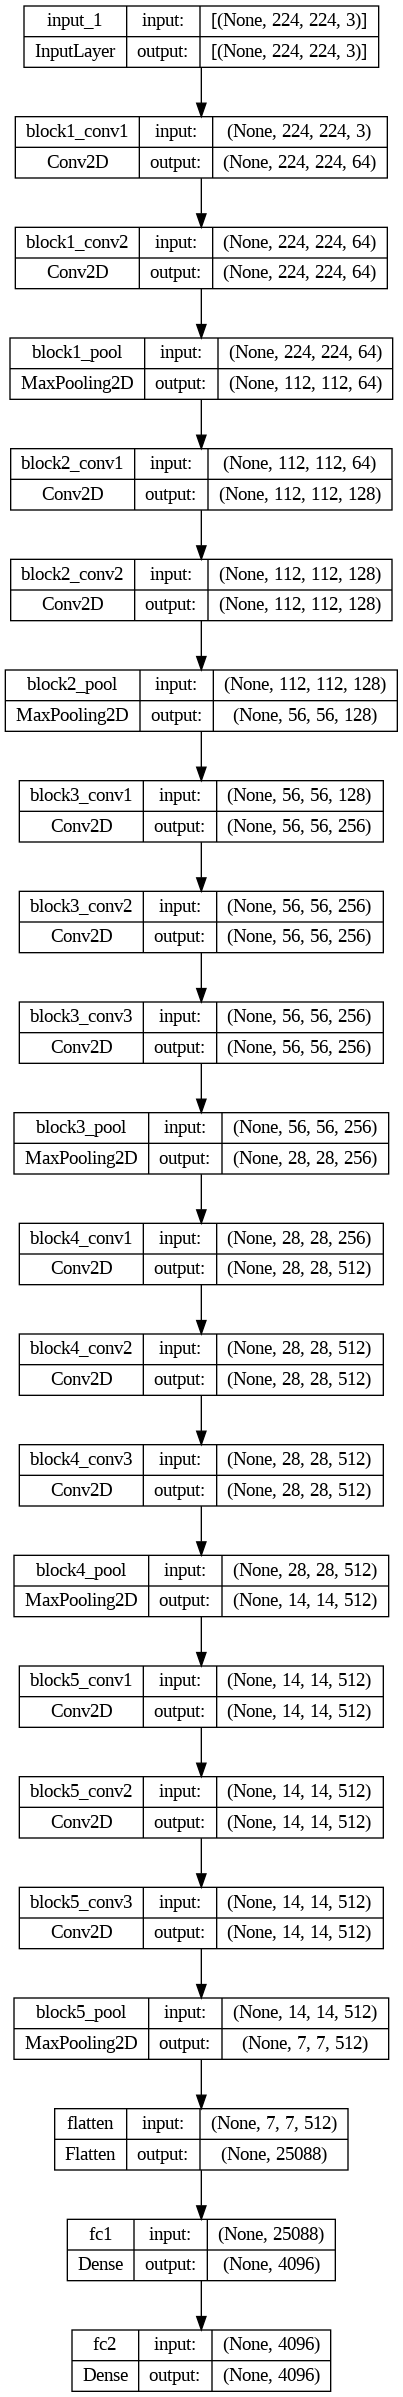

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input #to preprocess the data
# load vgg16 model
model = VGG16()
# restructure the model
# no need of last(prediction) layer. only need feature extraction
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())
# plot the model for visualizing the architecture
plot_model(model, show_shapes=True)

# **Extract the dataset**

In [ ]:
# Define the path to the zip file in Google Drive
zipPath = '/content/drive/MyDrive/Deep_Learning/Dataset/Image caption generator Dataset.zip'

# Define the path to extract the contents
extractPath = '/content/drive/MyDrive/Deep_Learning/Dataset'

# Create the extraction directory if it doesn't exist
import os
os.makedirs(extractPath, exist_ok=True)

# Extract the zip file
import zipfile
with zipfile.ZipFile(zipPath, 'r') as zipRef:
    zipRef.extractall(extract h)

print(f'Files extracted to {extractPath}')

# **Extract Image Features**

In [ ]:
# Image data directory
imgDir = '/content/drive/MyDrive/Deep_Learning/Dataset/Image caption generator Dataset/Images'
# dictionary to store features
imgFeatures = {}
# directory to the images
directory = os.path.join(imgDir)

for imgName in tqdm(os.listdir(directory)):
    # image path to load the image
    imgPath = directory + '/' + imgName
    # load the image from file
    image = load_img(imgPath, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model (3 dimention RGB)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg (method given by preprocess)
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    imgId = imgName.split('.')[0]
    # store feature
    imgFeatures[imgId] = feature

# **Save features in Drive**

In [ ]:
# Directry to save image features
saveDir = '/content/drive/MyDrive/Deep_Learning/Model_01/Extracted_Features'
# Save features to drive (write binary)
pickle.dump(imgFeatures, open(os.path.join(saveDir, 'features.pkl'), 'wb'))

# **Load features from Drive**

In [4]:
# Directry to save image features
saveDir = '/content/drive/MyDrive/Deep_Learning/Model_01/Extracted_Features'
# load features from saved directory (read binary)
with open(os.path.join(saveDir, 'features.pkl'), 'rb') as featureFile:
    imgFeatures = pickle.load(featureFile)

In [5]:
imgFeatures

{'3558370311_5734a15890': array([[1.0803216, 7.1813526, 0.7235749, ..., 0.       , 0.6327092,
         0.       ]], dtype=float32),
 '3435015880_eda46ff50f': array([[2.8343701 , 0.35778838, 0.        , ..., 0.        , 1.2891579 ,
         2.0053084 ]], dtype=float32),
 '2978810122_183e60ff2d': array([[0.       , 0.       , 4.208027 , ..., 0.       , 1.2609651,
         1.7707274]], dtype=float32),
 '2978236380_fb24c43f1e': array([[1.6389114 , 2.995778  , 0.        , ..., 0.        , 0.        ,
         0.94004387]], dtype=float32),
 '3346040664_5b584e6133': array([[0.       , 2.2889543, 0.       , ..., 0.       , 4.5477467,
         4.4719396]], dtype=float32),
 '382701159_f98c1988cd': array([[0.45956594, 0.        , 1.2120761 , ..., 0.        , 1.9892228 ,
         2.2612119 ]], dtype=float32),
 '1087168168_70280d024a': array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         3.0416744]], dtype=float32),
 '2711720095_0b98426d3c': array([[0.       , 0.       , 1.8

# **Load the Captions Data**

In [6]:
captionDir = '/content/drive/MyDrive/Deep_Learning/Dataset/Image caption generator Dataset/captions.txt'
with open(os.path.join(captionDir), 'r') as captionFile:
    # to skip first line (images , captions)
    next(captionFile)
    # read all captions
    captionsText = captionFile.read()

In [7]:
# to see few captions
captionsText[:1000]

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

# **Seperate Captions for Each Image**

In [8]:
# create mapping of image to captions
mappingImgToCaption = {}
# go through the lines and split
for line in tqdm(captionsText.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    # ignore error texts
    if len(line) < 2:
        continue
    imageId, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    imageId = imageId.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if image has more thatn 1 caption
    if imageId not in mappingImgToCaption:
        mappingImgToCaption[imageId] = []
    # store the caption
    mappingImgToCaption[imageId].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
mappingImgToCaption

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [10]:
# to see the number of captions
captionsLength = len(mappingImgToCaption)
captionsLength

8091

## **Preprocess Captions**

In [11]:
def clean(mappingImgToCaption):
    for key, captions in mappingImgToCaption.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing
            # convert to lowercase
            caption = caption.lower()
            # remove digits, special chars and etc
            caption = caption.replace('[^A-Za-z]', '')
            # remove extra spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startOfCaption ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endOfCaption'
            captions[i] = caption

In [12]:
# all captions of one image
mappingImgToCaption['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# preprocess the captions
clean(mappingImgToCaption)

In [14]:
# after preprocess of captions
mappingImgToCaption['1000268201_693b08cb0e']

['startOfCaption child in pink dress is climbing up set of stairs in an entry way endOfCaption',
 'startOfCaption girl going into wooden building endOfCaption',
 'startOfCaption little girl climbing into wooden playhouse endOfCaption',
 'startOfCaption little girl climbing the stairs to her playhouse endOfCaption',
 'startOfCaption little girl in pink dress going into wooden cabin endOfCaption']

In [15]:
# list for all captions
allCaptions = []
# store all captions in list
for key in mappingImgToCaption:
    for caption in mappingImgToCaption[key]:
        allCaptions.append(caption)

In [16]:
# number of captions
len(allCaptions)

40455

In [17]:
# first 10 captions
allCaptions[:10]

['startOfCaption child in pink dress is climbing up set of stairs in an entry way endOfCaption',
 'startOfCaption girl going into wooden building endOfCaption',
 'startOfCaption little girl climbing into wooden playhouse endOfCaption',
 'startOfCaption little girl climbing the stairs to her playhouse endOfCaption',
 'startOfCaption little girl in pink dress going into wooden cabin endOfCaption',
 'startOfCaption black dog and spotted dog are fighting endOfCaption',
 'startOfCaption black dog and tri-colored dog playing with each other on the road endOfCaption',
 'startOfCaption black dog and white dog with brown spots are staring at each other in the street endOfCaption',
 'startOfCaption two dogs of different breeds looking at each other on the road endOfCaption',
 'startOfCaption two dogs on pavement moving toward each other endOfCaption']

In [18]:
# tokenize the text (getting words of captions)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(allCaptions)
vocabularySize = len(tokenizer.word_index) + 1

In [19]:
vocabularySize

8485

In [20]:
# get maximum length of the caption available
maxLength = max(len(caption.split()) for caption in allCaptions)
maxLength

35


# **Split data to train and test**


In [21]:
imageIds = list(mappingImgToCaption.keys())
# 90% data for training
# 10% data for testing
DataSplit = int(len(imageIds) * 0.90)
train = imageIds[:DataSplit]
print("train :" + str(len(train)))
test = imageIds[DataSplit:]
print("test :" + str(len(test)))

train :7281
test :810


# **Function for Generating Data to Input**

In [22]:
# create data generator to get data in batch (avoids session crash)
def dataGenerator(dataKeys, mappingImgToCaption, features, tokenizer, maxLength, vocabularySize, batchSize):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in dataKeys:
            n += 1
            captions = mappingImgToCaption[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    inputSeqence, outputSeq = seq[:i], seq[i]
                    # pad input sequence
                    inputSeqence = pad_sequences([inputSeqence], maxlen=maxLength)[0]
                    # encode output sequence
                    outputSeq = to_categorical([outputSeq], num_classes=vocabularySize)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(inputSeqence)
                    y.append(outputSeq)
            if n == batchSize:
                # convert lists to numpy arrays
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

# **Model Creation**


---



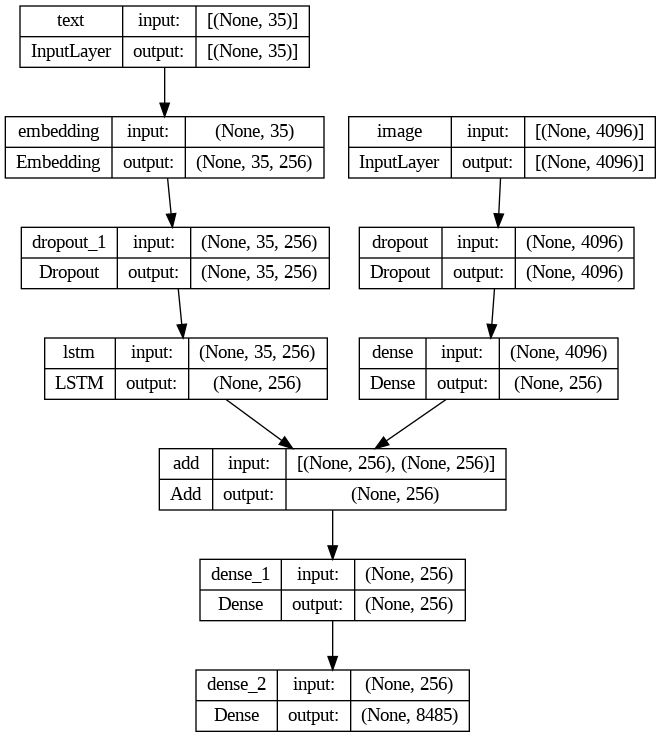

In [23]:
# modeling encoder
# image feature layers
input1 = Input(shape=(4096,), name="image")
firstEncoder1 = Dropout(0.4)(input1)
firstEncoder2 = Dense(256, activation='relu')(firstEncoder1)
# sequence feature layers
input2 = Input(shape=(maxLength,), name="text")
secondEncoder1 = Embedding(vocabularySize, 256, mask_zero=True)(input2)
secondEncoder2 = Dropout(0.4)(secondEncoder1)
secondEncoder3 = LSTM(256)(secondEncoder2)

# modeling decoder
decoder1 = add([firstEncoder2, secondEncoder3])
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocabularySize, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=output)
# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# plot the model
plot_model(model, show_shapes=True)

# **Train the model**

In [24]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Directory to save the model checkpoints
checkpoint_dir = '/content/drive/MyDrive/Deep_Learning/ModelCheckpoints_Model01'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.keras'),
    save_weights_only=False,  # Save the model architecture along with weights
    save_freq='epoch',  # Save after each epoch
    verbose=1  # Enable verbose output for saving
)

# Set parameters
epochs = 100
batchSize = 32
steps = len(train) // batchSize

# Create data generator
generator = dataGenerator(train, mappingImgToCaption, imgFeatures, tokenizer, maxLength, vocabularySize, batchSize)

# Fit the model for the entire number of epochs, using the checkpoint callback
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/100
227/227 [==============================] - ETA: 0s - loss: 5.2582 - accuracy: 0.1465
Epoch 1: saving model to /content/drive/MyDrive/Deep_Learning/ModelCheckpoints_Model01/model_epoch_01.keras
227/227 [==============================] - 74s 291ms/step - loss: 5.2582 - accuracy: 0.1465
Epoch 2/100
227/227 [==============================] - ETA: 0s - loss: 4.0495 - accuracy: 0.2500
Epoch 2: saving model to /content/drive/MyDrive/Deep_Learning/ModelCheckpoints_Model01/model_epoch_02.keras
227/227 [==============================] - 58s 256ms/step - loss: 4.0495 - accuracy: 0.2500
Epoch 3/100
227/227 [==============================] - ETA: 0s - loss: 3.6119 - accuracy: 0.2852
Epoch 3: saving model to /content/drive/MyDrive/Deep_Learning/ModelCheckpoints_Model01/model_epoch_03.keras
227/227 [==============================] - 57s 253ms/step - loss: 3.6119 - accuracy: 0.2852
Epoch 4/100
227/227 [==============================] - ETA: 0s - loss: 3.3406 - accuracy: 0.3038
Epoch 4: sav

# **Load the Model**

In [26]:
import tensorflow as tf

# Specify the path to the saved model file
model_path = '/content/drive/MyDrive/Deep_Learning/ModelCheckpoints/model_epoch_50.keras'

# Load the model
model = tf.keras.models.load_model(model_path)

# Verify the model summary to ensure it has been loaded correctly
model.summary()

# **Save the Best model**

In [27]:
modelSaveDir = '/content/drive/MyDrive/Deep_Learning/'
model.save(saveDir+'/bestModel_01.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Generate Captions**



---



### Function to convert indexes to words

In [28]:
# functin for convert index to word
def indexToWord(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

### Function to predict captions

In [29]:
# generate caption for an image
def predictCaption(model, image, tokenizer, maxLength):
    # add start tag for generation process
    inputText = 'startOfCaption'
    # iterate over the max length of sequence
    for i in range(maxLength):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([inputText])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxLength)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = indexToWord(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        inputText += " " + word
        # stop when reach end tag
        if word == 'endofcaption':
            break

    return inputText

# Evaluating using **BLEU**

In [30]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mappingImgToCaption[key]
    # predict the caption for image
    prediction = predictCaption(model, imgFeatures[key], tokenizer, maxLength)
    # split into words
    actualCaptions = [caption.split() for caption in captions]
    prediction = prediction.split()
    # append to the list
    actual.append(actualCaptions)
    predicted.append(prediction)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.412964
BLEU-2: 0.236090


### Function for Generate Captions

In [31]:
dataDir = '/content/drive/MyDrive/Deep_Learning/Dataset/Image caption generator Dataset/'
def generateCaption(imageName):
    # load a image
    # imageName = "1001773457_577c3a7d70.jpg"
    imageId = imageName.split('.')[0]
    imgPath = os.path.join(dataDir, "Images", imageName)
    image = Image.open(imgPath)
    captions = mappingImgToCaption[imageId]
    print('Actual: ')
    for caption in captions:
        print(caption)
    # predict the caption
    prediction = predictCaption(model, imgFeatures[imageId], tokenizer, maxLength)
    print('Predicted:')
    print(prediction)
    plt.imshow(image)

# Generate Captions for few Images


---

Actual: 
startOfCaption black dog and spotted dog are fighting endOfCaption
startOfCaption black dog and tri-colored dog playing with each other on the road endOfCaption
startOfCaption black dog and white dog with brown spots are staring at each other in the street endOfCaption
startOfCaption two dogs of different breeds looking at each other on the road endOfCaption
startOfCaption two dogs on pavement moving toward each other endOfCaption
Predicted:
startOfCaption two dogs are playing together in the dirt endofcaption


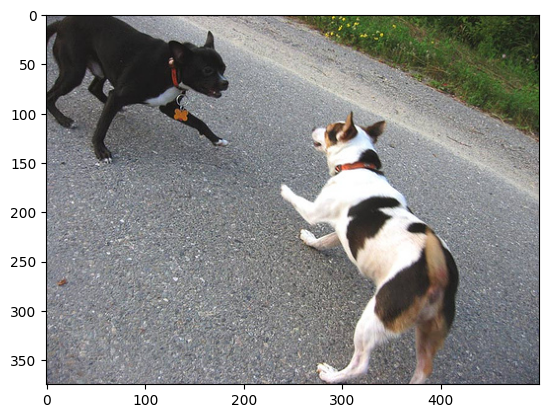

In [32]:
generateCaption("1001773457_577c3a7d70.jpg")

Actual: 
startOfCaption brown and white dog is running through the snow endOfCaption
startOfCaption dog is running in the snow endOfCaption
startOfCaption dog running through snow endOfCaption
startOfCaption white and brown dog is running through snow covered field endOfCaption
startOfCaption the white and brown dog is running over the surface of the snow endOfCaption
Predicted:
startOfCaption white dog with red collar is running through snow endofcaption


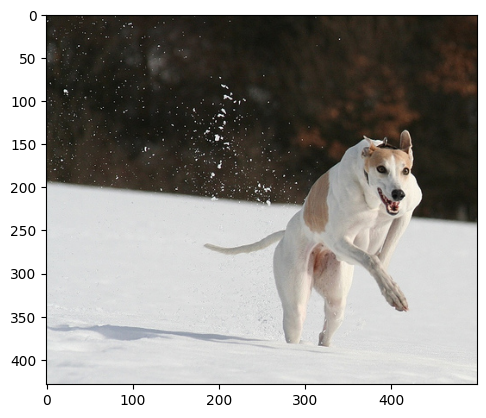

In [33]:
generateCaption("101654506_8eb26cfb60.jpg")

Actual: 
startOfCaption the children are playing in the water endOfCaption
startOfCaption "two boys one with yellow and orange ball play in some water in front of field ." endOfCaption
startOfCaption two boys play in puddle endOfCaption
startOfCaption two children play with balloon in mud on sunny day endOfCaption
startOfCaption two kids are running and playing in some water endOfCaption
Predicted:
startOfCaption two people play in mud fountain endofcaption


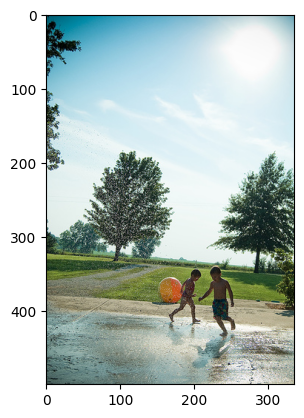

In [35]:
generateCaption("1056249424_ef2a2e041c.jpg")

Actual: 
startOfCaption black and white dog is attempting to catch yellow and purple object in low cut yard endOfCaption
startOfCaption black and white dog jumps after yellow toy endOfCaption
startOfCaption black and white dog jumps to get the frisbee endOfCaption
startOfCaption black dog is jumping up to catch purple and green toy endOfCaption
startOfCaption dog jumps to catch toy endOfCaption
Predicted:
startOfCaption black and white dog is jumping over low yard endofcaption


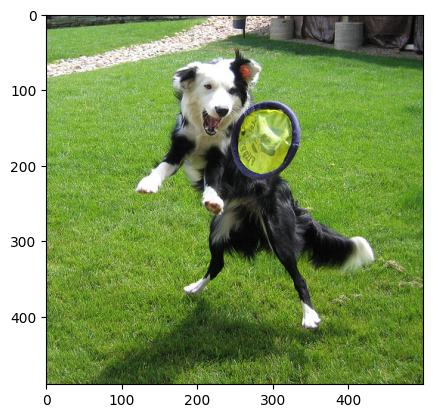

In [36]:
generateCaption("1067180831_a59dc64344.jpg")

Actual: 
startOfCaption group of backpackers lay on the dry ground endOfCaption
startOfCaption group of hikers are resting on the ground in front of some mountains endOfCaption
startOfCaption people camp with the mountains in the background endOfCaption
startOfCaption several hikers rest with their gear in front of mountain endOfCaption
startOfCaption the group of hikers is resting in front of mountain endOfCaption
Predicted:
startOfCaption group of people sitting in front of mountain range endofcaption


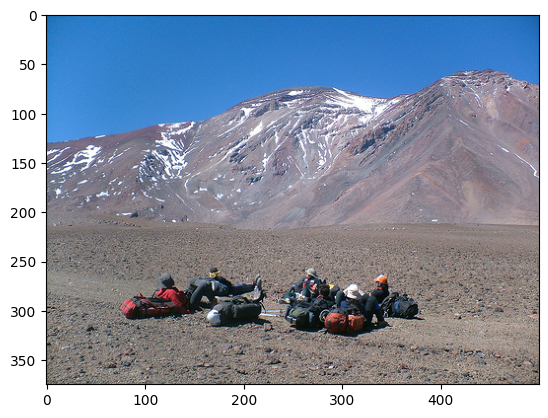

In [39]:
generateCaption("1093716555_801aacef79.jpg")

Actual: 
startOfCaption black and white bird eating seeds out of someone 's hand endOfCaption
startOfCaption black and white bird standing on hand endOfCaption
startOfCaption small bird sits in person 's hand and eats seeds endOfCaption
startOfCaption black and white bird standing on hand of someone holding sunflower seeds endOfCaption
startOfCaption the small bird is clinging to finger of the hand holding the seeds endOfCaption
Predicted:
startOfCaption white and blue bird is above hand endofcaption


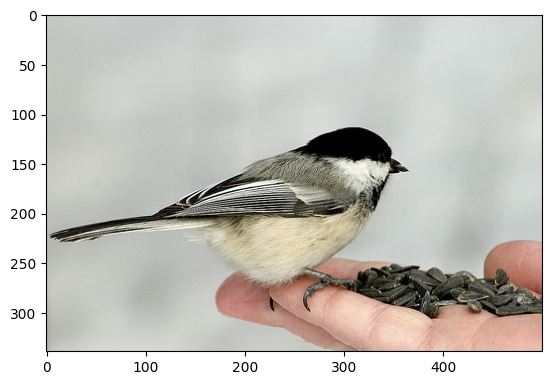

In [44]:
generateCaption("111766423_4522d36e56.jpg")